In [ ]:
# Для функционирования watermark - раскомментируйте строку ниже, либо установите библиотеку в консоли вручную
# !pip install watermark
%load_ext watermark

In [ ]:
# %watermark -v -m -p numpy,scipy,matplotlib,pandas,sklearn,seaborn,tqdm -g

In [41]:
# Future Python versions compatibility
from __future__ import division

# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

# System libraries
import os
import random

# Object libraries
import pandas as pd
import numpy as np
import seaborn as sns

# ML libraries
from sklearn.svm import SVR
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, make_scorer

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# Data Transformers
from sklearn.preprocessing import LabelEncoder,PowerTransformer, StandardScaler
from collections import Counter
from sklearn.compose import ColumnTransformer

# Visualize libraries
import matplotlib.pyplot as plt
import matplotlib.colors as colors

# Colors map
colors_list = list(colors._colors_full_map.values())
cust_palt = [
            '#111d5e', 
            '#c70039', 
            '#f37121', 
            '#ffbd69', 
            '#ffc93c',
            ]
plt.style.use('ggplot')
%matplotlib inline

In [28]:
os.path.abspath(os.getcwd())

'/home/tater/Technopark/Sem_2/ML_Ops/notebooks'

In [29]:
def seed_all(seed):
    
    ''' A function to seed everything for getting stable results and reproducibility'''
    
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

seed = 42    
seed_all(seed)

In [31]:
def missing_values_table(df : pd.DataFrame) -> pd.DataFrame:
    """Missing values detection function"""
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
                                mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
                                '% of Total Values', ascending=False).round(2)

    print("Your selected dataframe has "  + str(df.shape[0]) + " objects with " + str(df.shape[1]) 
                                          + " features.\n"
                             "There are " + str(mis_val_table_ren_columns.shape[0]) +
                             " features that have missing values.")

    return mis_val_table_ren_columns

In [22]:
data_path = os.path.join(os.path.dirname(os.getcwd()), "ml_project/data")
raw_data_filename = "heart_cleveland_upload.csv"

In [25]:
raw_data = pd.read_csv(os.path.join(data_path, raw_data_filename))
raw_data

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,condition
0,69,1,0,160,234,1,2,131,0,0.1,1,1,0,0
1,69,0,0,140,239,0,0,151,0,1.8,0,2,0,0
2,66,0,0,150,226,0,0,114,0,2.6,2,0,0,0
3,65,1,0,138,282,1,2,174,0,1.4,1,1,0,1
4,64,1,0,110,211,0,2,144,1,1.8,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
292,40,1,3,152,223,0,0,181,0,0.0,0,0,2,1
293,39,1,3,118,219,0,0,140,0,1.2,1,0,2,1
294,35,1,3,120,198,0,0,130,1,1.6,1,0,2,1
295,35,0,3,138,183,0,0,182,0,1.4,0,0,0,0


In [32]:
missing_values_table(raw_data)

Your selected dataframe has 297 objects with 14 features.
There are 0 features that have missing values.


,Missing Values,% of Total Values


In [33]:
# Renaming columns.
raw_data.columns = [
                    'age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 
                    'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
                    'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 
                    'thalassemia', 'condition',
                   ]

In [34]:
# Number of unique train observartions:
raw_data.nunique()

age                         41
sex                          2
chest_pain_type              4
resting_blood_pressure      50
cholesterol                152
fasting_blood_sugar          2
rest_ecg                     3
max_heart_rate_achieved     91
exercise_induced_angina      2
st_depression               40
st_slope                     3
num_major_vessels            4
thalassemia                  3
condition                    2
dtype: int64

In [35]:
# Renaming cateorical data for easier understanding:

raw_data['sex'] = raw_data['sex'].map({0:'female',
                                       1:'male'})
raw_data['chest_pain_type'] = raw_data['chest_pain_type'].map({0:'typical_angina',
                                                         1:'atypical_angina', 
                                                         2:'non_anginal_pain',
                                                         3:'asymptomatic',
                                                         })
raw_data['fasting_blood_sugar'] = raw_data['fasting_blood_sugar'].map({0:'less_than_120mg/ml',
                                                                 1:'greater_than_120mg/ml',
                                                                })
raw_data['rest_ecg'] = raw_data['rest_ecg'].map({0:'normal',
                                           1:'ST-T_wave_abnormality',
                                           2:'left_ventricular_hypertrophy',
                                          })
raw_data['exercise_induced_angina'] = raw_data['exercise_induced_angina'].map({0:'no',
                                                                         1:'yes'})
raw_data['st_slope'] = raw_data['st_slope'].map({0:'upsloping',
                                           1:'flat',
                                           2:'downsloping',
                                          })
raw_data['thalassemia'] = raw_data['thalassemia'].map({1:'fixed_defect',
                                                 0:'normal',
                                                 2:'reversable_defect',
                                                })
raw_data['condition'] = raw_data['condition'].map({0:'no_disease', 
                                             1:'has_disease'})

In [36]:
# Masks for easier selection in future:
categorical = [item for item in raw_data.loc[:, raw_data.nunique() <= 10]]
continuous = [item for item in raw_data.loc[:, raw_data.nunique() >= 10]]

In [37]:
def ctg_dist(df, cols, hue=None,rows=3, columns=3):
    
    '''A function for displaying cateorical distribution'''
    
    fig, axes = plt.subplots(rows, columns, figsize=(16, 12))
    axes = axes.flatten()

    for i, j in zip(df[cols].columns, axes):
        sns.countplot(x=i,
                    data=df,
                    palette=cust_palt,
                    hue=hue,
                    ax=j,
                    order=df[i].value_counts().index)
        j.tick_params(labelrotation=10)
        
        total = float(len(df[i]))
        
        j.set_title(f'{str(i).capitalize()} Distribution')
        
        
        for p in j.patches:
            height = p.get_height()
            j.text(p.get_x() + p.get_width() / 2.,
                    height + 2,
                    '{:1.2f}%'.format((height / total) * 100),
                    ha='center')
        
        plt.tight_layout()

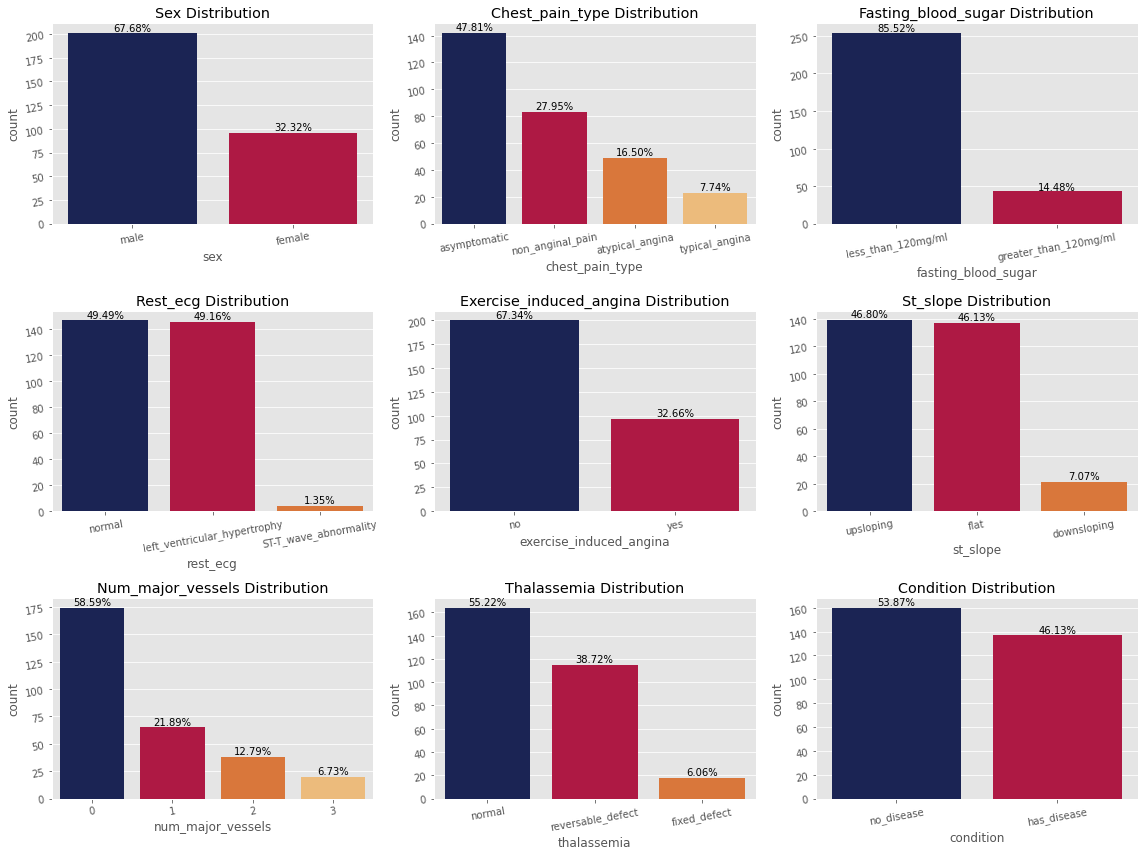

In [42]:
# Display categorical data
ctg_dist(raw_data, categorical)